# Before starting & [RQ 1]

## Libraries import

In [1]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import spearmanr

## Get the dataset (from Kaggle)

First of all, we need to get the steam-reviews-2021.csv file from Kaggle

In [2]:
# Downloads the "steam-reviews-2021" dataset from Kaggle
!kaggle datasets download najzeko/steam-reviews-2021

Dataset URL: https://www.kaggle.com/datasets/najzeko/steam-reviews-2021
License(s): GPL-2.0
 99% 2.96G/2.97G [00:40<00:00, 119MB/s]
100% 2.97G/2.97G [00:40<00:00, 78.6MB/s]


Then we have to unzip the .zip file

In [3]:
!unzip '/content/steam-reviews-2021.zip'

Archive:  /content/steam-reviews-2021.zip
  inflating: steam_reviews.csv       


## Considerations about the dataset import in a Pandas DataFrame

We define the filepath of the unzipped dataset

In [4]:
dataset_filepath = '/content/steam_reviews.csv'

Due to the large dimension of the dataset (more than 8 GB, 22 millions or raws, 23 columns), using a standard CPU processor in Google Colaboratory, we would not have the resources needed to import our dataset into a Pandas DataFrame with a simple use of the read_csv() function, like the one below:
```
dataframe = pd.read_csv(dataset_filepath)
```

Incidentally, we could successfully execute the above command using a TPU processor, available in Google Colaboratory. This process would take about 2-3 minutes and would require approximately 17 GB of RAM.

Assuming, however, that the task was designed to test us under more "conventional" conditions, we will import the dataset using a chunk approach (like in the dafult configuration in Google Colaboratory), by dividing the original dataset into smaller pieces of the dataset, using the least possible amount of data in carrying out our analyses.

We create a first "little" DataFrame importing just a portion of the total raws in order to:

*   make an initial exploration of the dataset
*   defining a more efficient management of data types that we will import later


In [5]:
df_first_raws = pd.read_csv(dataset_filepath, nrows=1000000)

We make an initial exploration of this first DataFrame

In [6]:
# Display the dataset info()
df_first_raws.info()

# Display the first 5 rows
print("First 5 rows of the dataset:")
print(df_first_raws.head().to_markdown(index=False, numalign="left", stralign="left", tablefmt="grid"))

# Generate descriptive statistics for numerical columns
print("\nDescriptive statistics:")
print(df_first_raws.describe().to_markdown(numalign="left", stralign="left", tablefmt="grid"))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 23 columns):
 #   Column                          Non-Null Count    Dtype  
---  ------                          --------------    -----  
 0   Unnamed: 0                      1000000 non-null  int64  
 1   app_id                          1000000 non-null  int64  
 2   app_name                        1000000 non-null  object 
 3   review_id                       1000000 non-null  int64  
 4   language                        1000000 non-null  object 
 5   review                          998242 non-null   object 
 6   timestamp_created               1000000 non-null  int64  
 7   timestamp_updated               1000000 non-null  int64  
 8   recommended                     1000000 non-null  bool   
 9   votes_helpful                   1000000 non-null  int64  
 10  votes_funny                     1000000 non-null  int64  
 11  weighted_vote_score             1000000 non-null  float64
 12  c

Looking at the results obtained, we can first of all have a more precise idea of the structure of the dataset

Below is a brief description of each column of the dataset:

1. **app_id**: the application unique identification number
2. **app_name**: the name of the game
3. **review_id**: unique identity of review
4. **language**: language used in review
5. **review**: the actual review
6. **timestamp_created**: date the review was created (unix
timestamp)
7. **timestamp_updated**: date the review was last updated (unix
timestamp)
8. **recommended**: true means it was a positive recommendation
9. **votes_helpful**: the number of users that found this review
helpful
10. **votes_funny**: the number of users that found this review funny
11. **weighted_vote_score**: helpfulness score
12. **comment_count**: number of comments posted on this review
13. **steam_purchase**: true if the user purchased the game on
Steam
14. **received_for_free**: true if the user checked a box saying they
got the app for free
15. **written_during_early_access**: true if the user posted this
review while the game was in Early Access

Author fields:

16. **steamid**: the user’s SteamID
17. **num_games_owned**: number of games owned by the user
18. **num_reviews**: number of reviews written by the user
19. **playtime_forever**: lifetime playtime tracked in this app
20. **playtime_last_two_weeks**: playtime tracked in the past two
weeks for this app
21. **playtime_at_review**: playtime when the review was written
22. **last_played**: time for when the user last played

Secondly, in order to defining a more efficient management of data types, we underlines that:

*   there are three columns with Unix timestamps that will need to be converted to datetime format: **timestamp_created**, **timestamp_updated** and **author.last_played**
*   there are three columns that it might be useful to convert to string format: **app_name**, **language** and **review** (the latter especially because of its potential length)

# Research questions (RQs)

## [RQ 2]

---

*Let's explore the dataset by analyzing the distribution of reviews across different applications.*

* *Identify which applications have the highest and lowest number of reviews*
* *Plot the number of reviews for each application in descending order. What insights can you draw from the plot?*
* *For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities*
* *Which applications have the most and the least user recommendations? Summarize your findings*
* *Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship.*

---

We create a DataFrame using the chunk approach and importing only the columns of interest to answer all the questions of RQ 2

In [7]:
# set chunk size: 1 million
chunksize = 1000000
# empty list to store the dataframes
data_frames = []

# Iterate over the dataset in chunks
# usecols: considering just the columns below
for chunk in pd.read_csv(dataset_filepath, chunksize=chunksize, usecols=['app_id', 'app_name', 'review_id',
                                                                         'steam_purchase', 'received_for_free',
                                                                         'recommended', 'weighted_vote_score']):
    data_frames.append(chunk)

# Concatenate the chunks into a single dataframe
df_combined = pd.concat(data_frames, ignore_index=True)

### Identify which applications have the highest and lowest number of reviews

*   The application with the **highest number** of **reviews** is **PLAYERUNKNOWN'S BATTLEGROUNDS**
*   The application with the **lowest number** of **reviews** is **Neon Hardcorps**



In [8]:
# Group by app_id and app_name, count review_id
review_counts = df_combined.groupby(['app_id', 'app_name'])['review_id'].count()

# App with the highest number of reviews
highest_reviews = review_counts.idxmax()
print(f"App with the highest number of reviews: {highest_reviews[1]} (app_id: {highest_reviews[0]}), {review_counts.max()} reviews")

# App with the lowest number of reviews
lowest_reviews = review_counts.idxmin()
print(f"App with the lowest number of reviews: {lowest_reviews[1]} (app_id: {lowest_reviews[0]}), {review_counts.min()} reviews")

App with the highest number of reviews: PLAYERUNKNOWN'S BATTLEGROUNDS (app_id: 578080), 1644255 reviews
App with the lowest number of reviews: Neon Hardcorps (app_id: 454200), 200 reviews


### Plot the number of reviews for each application in descending order. What insights can you draw from the plot?

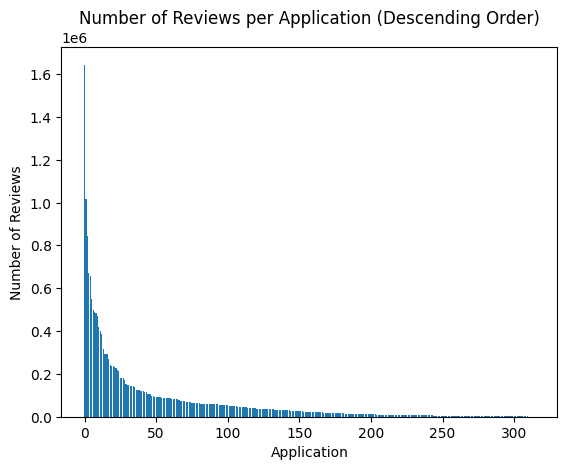

In [9]:
# Sort the review counts in descending order
sorted_review_counts = review_counts.sort_values(ascending=False)

# Create the plot
plt.bar(range(len(sorted_review_counts)), sorted_review_counts.values)
plt.xlabel("Application")
plt.ylabel("Number of Reviews")
plt.title("Number of Reviews per Application (Descending Order)")
plt.show()

The plot of the number of reviews for each application shows us a long-tailed distribution (something very close to Chris Anderson theory)

Below we add some explanatory data.

* 315 apps in total
* the first 10 app for number of reviews represent the 34% of the total reviews
* the remaining 305 apps represent the remaining 66% of total reviews (market niches, see Anderson above)

In [10]:
# Total number of app_id
total_app_ids = df_combined['app_id'].nunique()
print(f"Total number of distinct app_ids: {total_app_ids}")

# Table with top ten app_id (and app_name) for review_id (descending order)
review_counts = df_combined.groupby(['app_id', 'app_name'])['review_id'].count().sort_values(ascending=False)
total_reviews = review_counts.sum()
top_10_apps = review_counts.head(10).reset_index()
top_10_apps.rename(columns={'review_id': 'review_count'}, inplace=True)
top_10_apps['percentage'] = (top_10_apps['review_count'] / total_reviews) * 100
print("\nTop 10 apps by review count:")
print(top_10_apps[['app_id', 'app_name', 'review_count', 'percentage']].to_markdown(index=False))

# Percentage weight of the top 10 apps on the total number of review_id
top_10_percentage = top_10_apps['percentage'].sum()
print(f"\nPercentage weight of the top 10 apps: {top_10_percentage:.2f}%")

# Percentage weight of the remaining apps on the total number of review_id
remaining_percentage = 100 - top_10_percentage
print(f"Percentage weight of the remaining apps: {remaining_percentage:.2f}%")

Total number of distinct app_ids: 315

Top 10 apps by review count:
|   app_id | app_name                       |   review_count |   percentage |
|---------:|:-------------------------------|---------------:|-------------:|
|   578080 | PLAYERUNKNOWN'S BATTLEGROUNDS  |        1644255 |      7.56071 |
|   271590 | Grand Theft Auto V             |        1019116 |      4.68616 |
|   359550 | Tom Clancy's Rainbow Six Siege |         841918 |      3.87136 |
|   105600 | Terraria                       |         672815 |      3.09378 |
|     4000 | Garry's Mod                    |         655524 |      3.01427 |
|   252490 | Rust                           |         549074 |      2.52478 |
|   252950 | Rocket League                  |         498565 |      2.29253 |
|   218620 | PAYDAY 2                       |         487747 |      2.24279 |
|   945360 | Among Us                       |         485293 |      2.2315  |
|   292030 | The Witcher 3: Wild Hunt       |         469395 |      2.1584

### For the top 5 applications by number of reviews, how many reviews came from users who purchased the application versus those who received it for free? Provide a percentage breakdown and highlight any similarities

We need to create a new DataFrame using the chunk approach and importing more columns of interest to answer the question

In [11]:
# Group by app_id and app_name, count review_id
review_counts = df_combined.groupby(['app_id', 'app_name'])['review_id'].count().sort_values(ascending=False)

# Get the top 5 applications
top_5_apps = review_counts.head(5)

# Iterate over the top 5 apps
for app_id, app_name in top_5_apps.index:
    app_reviews = df_combined[(df_combined['app_id'] == app_id)]
    purchased_reviews = app_reviews[app_reviews['steam_purchase'] == True].shape[0]
    free_reviews = app_reviews[app_reviews['received_for_free'] == True].shape[0]
    total_reviews = purchased_reviews + free_reviews

    print(f"For {app_name}:")
    print(f"- Purchased: {purchased_reviews} ({(purchased_reviews / total_reviews) * 100:.2f}%)")
    print(f"- Received for free: {free_reviews} ({(free_reviews / total_reviews) * 100:.2f}%)")
    print("-" * 20)

For PLAYERUNKNOWN'S BATTLEGROUNDS:
- Purchased: 1372721 (95.72%)
- Received for free: 61443 (4.28%)
--------------------
For Grand Theft Auto V:
- Purchased: 905288 (95.91%)
- Received for free: 38624 (4.09%)
--------------------
For Tom Clancy's Rainbow Six Siege:
- Purchased: 702505 (95.09%)
- Received for free: 36300 (4.91%)
--------------------
For Terraria:
- Purchased: 527762 (96.32%)
- Received for free: 20154 (3.68%)
--------------------
For Garry's Mod:
- Purchased: 551250 (95.70%)
- Received for free: 24765 (4.30%)
--------------------


It would seem that all five of these apps have the same percentage incidence of reviews written by users who have purchased the application: about 96%.

### Which applications have the most and the least user recommendations? Summarize your findings

In [12]:
# Group by app_id and app_name, count recommended
recommendations = df_combined.groupby(['app_id', 'app_name'])['recommended'].sum()

# App with the most recommendations
most_recommendations = recommendations.idxmax()
print(f"App with the most recommendations: {most_recommendations[1]} (app_id: {most_recommendations[0]}), {recommendations.max()} recommendations")

# App with the least recommendations
least_recommendations = recommendations.idxmin()
print(f"App with the least recommendations: {least_recommendations[1]} (app_id: {least_recommendations[0]}), {recommendations.min()} recommendations")

App with the most recommendations: PLAYERUNKNOWN'S BATTLEGROUNDS (app_id: 578080), 886417 recommendations
App with the least recommendations: Neon Hardcorps (app_id: 454200), 89 recommendations


Not surprisingly, we got a result closely related to what we had previously seen with the apps that got the most and fewest reviews (**PLAYERUNKNOWN'S BATTLEGROUNDS** with 1.644.255 reviews and **Neon Hardcorps** with 200 reviews)

Thinking in terms of recommendation rate (defined as the ratio between the number of recommendations and the number of reviews), one could obtain apparently more surprising results.

We report an example below, but one should never neglect the absolute values (or at least, not entirely; "niche" VS "broad" market)

In [13]:
# Group by app_id and app_name
grouped_data = df_combined.groupby(['app_id', 'app_name'])

# Calculate recommendations, review counts, and recommendation rate
app_stats = grouped_data.agg(
    recommendations=('recommended', 'sum'),
    review_count=('review_id', 'count'),
    recommendation_rate=('recommended', lambda x: x.sum() / len(x) if len(x) > 0 else 0)
)

# Find app with most recommendations
most_recommendations_app = app_stats['recommendations'].idxmax()
print("App with most recommendations:")
print(f"App Name: {most_recommendations_app[1]}")
print(f"Recommendations: {app_stats.loc[most_recommendations_app, 'recommendations']}")
print(f"Reviews: {app_stats.loc[most_recommendations_app, 'review_count']}")
print(f"Recommendation Rate: {app_stats.loc[most_recommendations_app, 'recommendation_rate']}")
print("-"*20)


# Find app with least recommendations
least_recommendations_app = app_stats['recommendations'].idxmin()
print("\nApp with least recommendations:")
print(f"App Name: {least_recommendations_app[1]}")
print(f"Recommendations: {app_stats.loc[least_recommendations_app, 'recommendations']}")
print(f"Reviews: {app_stats.loc[least_recommendations_app, 'review_count']}")
print(f"Recommendation Rate: {app_stats.loc[least_recommendations_app, 'recommendation_rate']}")
print("-"*20)


# Find app with highest recommendation rate
highest_rate_app = app_stats['recommendation_rate'].idxmax()
print("\nApp with highest recommendation rate:")
print(f"App Name: {highest_rate_app[1]}")
print(f"Recommendations: {app_stats.loc[highest_rate_app, 'recommendations']}")
print(f"Reviews: {app_stats.loc[highest_rate_app, 'review_count']}")
print(f"Recommendation Rate: {app_stats.loc[highest_rate_app, 'recommendation_rate']}")
print("-"*20)

# Find app with lowest recommendation rate
lowest_rate_app = app_stats['recommendation_rate'].idxmin()
print("\nApp with lowest recommendation rate:")
print(f"App Name: {lowest_rate_app[1]}")
print(f"Recommendations: {app_stats.loc[lowest_rate_app, 'recommendations']}")
print(f"Reviews: {app_stats.loc[lowest_rate_app, 'review_count']}")
print(f"Recommendation Rate: {app_stats.loc[lowest_rate_app, 'recommendation_rate']}")
print("-"*20)

App with most recommendations:
App Name: PLAYERUNKNOWN'S BATTLEGROUNDS
Recommendations: 886417
Reviews: 1644255
Recommendation Rate: 0.5390994705809014
--------------------

App with least recommendations:
App Name: Neon Hardcorps
Recommendations: 89
Reviews: 200
Recommendation Rate: 0.445
--------------------

App with highest recommendation rate:
App Name: ULTRAKILL
Recommendations: 5558
Reviews: 5584
Recommendation Rate: 0.9953438395415473
--------------------

App with lowest recommendation rate:
App Name: Identity
Recommendations: 439
Reviews: 1804
Recommendation Rate: 0.2433481152993348
--------------------


### Is there a correlation between the number of recommendations and the applications' review scores? Use a statistical test to confirm the significance of the relationship

In [15]:
import pandas as pd
from scipy.stats import spearmanr

# Group by app and calculate the sum of recommendations and the mean weighted vote score
app_stats = df_combined.groupby(['app_id', 'app_name']).agg(
    recommendations=('recommended', 'sum'),
    average_weighted_vote_score=('weighted_vote_score', 'mean')
).reset_index()

# Calculate Spearman's correlation
correlation, p_value = spearmanr(app_stats['recommendations'], app_stats['average_weighted_vote_score'])

print("Spearman's correlation:", correlation)
print("P-value:", p_value)

# Interpret the results
alpha = 0.05  # Significance level
if p_value < alpha:
    print("There is a statistically significant correlation between the number of recommendations and the average weighted vote score.")
else:
    print("There is no statistically significant correlation between the number of recommendations and the average weighted vote score.")

Spearman's correlation: -0.6258916454440435
P-value: 1.1618128912072842e-35
There is a statistically significant correlation between the number of recommendations and the average weighted vote score.


In [ ]:
del df_combined
del chunk
del data_frames

## [RQ 3]

---

*Understanding when users are most active in submitting reviews can help identify peak engagement periods*

* *Plot the number of reviews submitted each month and describe any trends*
* *Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice*
* *Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity*
* *What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis*
* *Create a function that accepts a list of time intervals and plots the number of reviews for each interval*
* *Use the function to plot the number of reviews for the following time intervals:*

*InitialTime FinalTime*

*00:00:00  02:59:59*

*03:00:00  05:59:59*

*06:00:00  10:59:59*

*11:00:00  13:59:59*

*14:00:00  16:59:59*

*17:00:00  19:59:59*

*20:00:00  23:59:59*

* Summarize your findings from the time interval analysis.


---

As done previously, we create a DataFrame that allows us to address RQ 3

In [18]:
# set chunk size: 1 million
chunksize = 1000000
# empty list to store the dataframes
data_frames = []

# Iterate over the dataset in chunks
# usecols: considering just the columns below
for chunk in pd.read_csv(dataset_filepath, chunksize=chunksize, usecols=['review_id',
                                                                         'timestamp_created', 'timestamp_updated',
                                                                         'recommended',
                                                                         'author.steamid', 'author.playtime_forever', 'author.playtime_last_two_weeks',
                                                                         'weighted_vote_score']):
    data_frames.append(chunk)

# Concatenate the chunks into a single DataFrame
df_combined = pd.concat(data_frames, ignore_index=True)

### Plot the number of reviews submitted each month and describe any trends

Now we can plot the number of reviews submitted each month.

We note:
* a considerable growth year on year, very evident since 2014
* a huge increase in 2020 (linked to the COVID-19 pandemic)
* repeated and significant increments during the months of December and the summer months (effect of school holidays, or less workload, and probably Christmas and/or end-of-school gifts, without forgetting the effects of discount campaigns such as Black Friday)



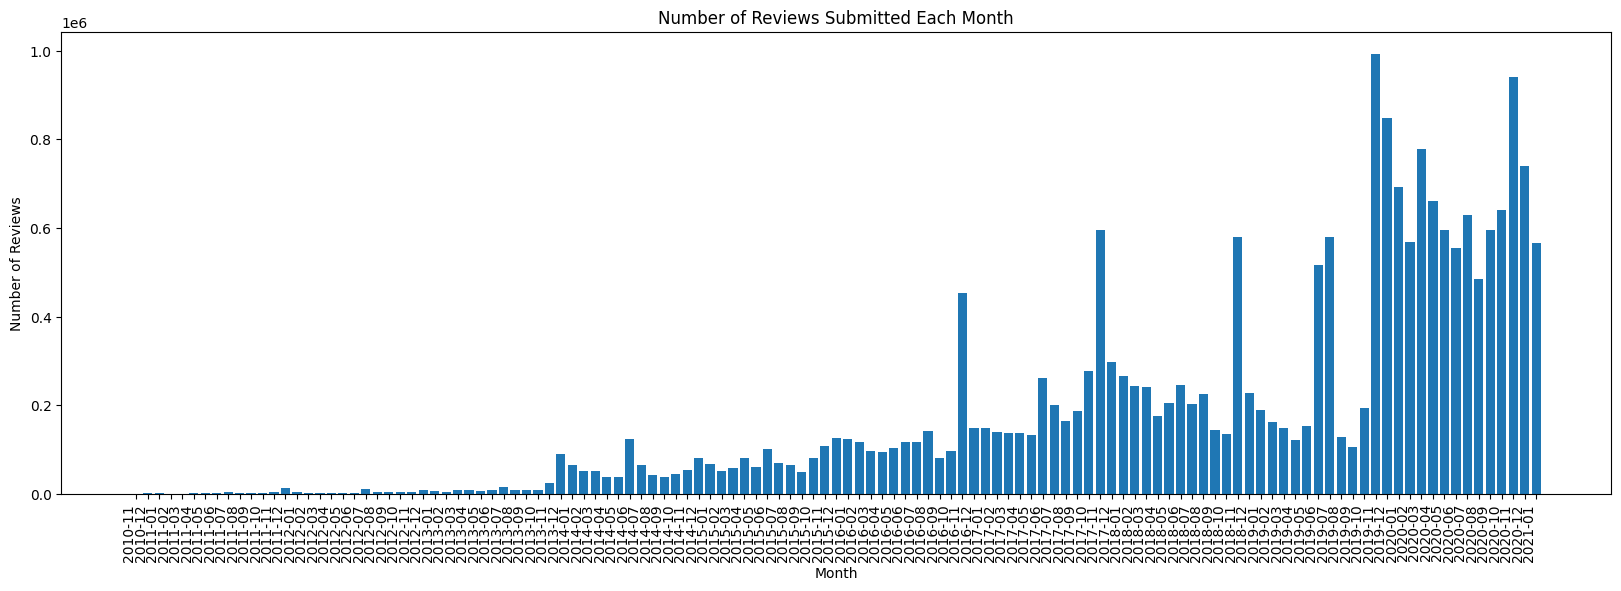

In [19]:
# Convert the timestamp_created column to datetime objects
df_combined['timestamp_created'] = pd.to_datetime(df_combined['timestamp_created'], unit='s')
# Extract the month from the timestamp_created column
df_combined['month'] = df_combined['timestamp_created'].dt.to_period('M')

# Group by month and count the number of reviews
monthly_reviews = df_combined.groupby('month')['review_id'].count()

# Create the plot
plt.figure(figsize=(20, 6))
plt.bar(monthly_reviews.index.astype(str), monthly_reviews.values)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Submitted Each Month')
plt.xticks(rotation=90, ha='right')
plt.show()

### Identify any seasonal patterns or trends in review activity. Explain any seasonal impact you notice

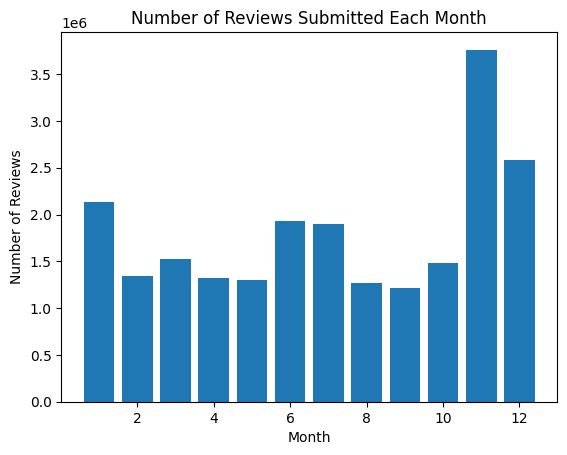

In [20]:
# Convert the timestamp_created column to datetime objects
df_combined['timestamp_created'] = pd.to_datetime(df_combined['timestamp_created'], unit='s')
# Extract the month from the timestamp_created column
df_combined['month'] = df_combined['timestamp_created'].dt.month

# Group by month and count the number of reviews
monthly_reviews = df_combined.groupby('month')['review_id'].count()

# Create the plot
plt.bar(monthly_reviews.index, monthly_reviews.values)
plt.xlabel('Month')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews Submitted Each Month')
plt.show()

### Determine if certain times of the year have higher engagement rates. Describe noticeable peaks in user activity

### What is the most common time of day users write reviews? For example, users might typically write reviews at 17:44. Explain how this time distribution could influence your analysis

The time slot in which users write the most reviews is the afternoon (it would seem after the morning commitments, school or work).

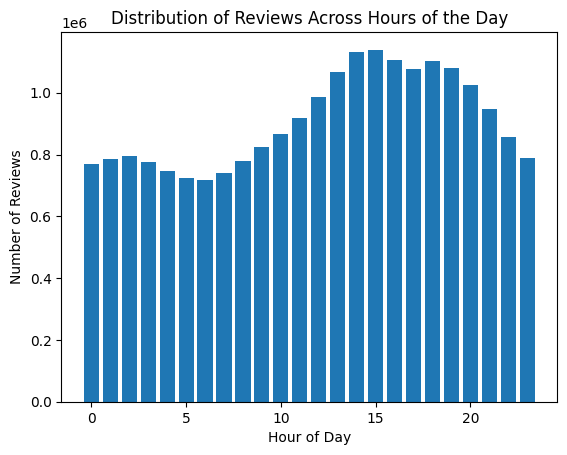

In [21]:
# Extract the hour from the timestamp_created column
df_combined['hour'] = df_combined['timestamp_created'].dt.hour

# Count the number of reviews for each hour
hourly_reviews = df_combined.groupby('hour')['review_id'].count()

# Plotting the distribution of reviews across hours
plt.figure()
plt.bar(hourly_reviews.index, hourly_reviews.values)
plt.xlabel("Hour of Day")
plt.ylabel("Number of Reviews")
plt.title("Distribution of Reviews Across Hours of the Day")
plt.show()

### Create a function that accepts a list of time intervals and plots the number of reviews for each interval

In [24]:
def plot_reviews_per_hour(df, intervals):
    df['timestamp_created'] = pd.to_datetime(df['timestamp_created'], unit='s')

    hourly_reviews = []
    for start, end in intervals:
        # Calculate interval duration in hours
        duration = pd.to_timedelta(pd.to_datetime(end) - pd.to_datetime(start)).total_seconds() / 3600

        # Filter and count reviews
        count = df[
            (df['timestamp_created'].dt.time >= pd.to_datetime(start).time()) &
            (df['timestamp_created'].dt.time <= pd.to_datetime(end).time())
        ].shape[0] # Get the number of rows (reviews)

        # Calculate and store reviews per hour
        hourly_reviews.append(count / duration)

    # Create the plot
    plt.bar([f"{start} - {end}" for start, end in intervals], hourly_reviews)
    plt.xlabel("Time Interval")
    plt.ylabel("Reviews per Hour")
    plt.title("Number of Reviews per Hour")
    plt.xticks(rotation=90)
    plt.show()

### Use the function to plot the number of reviews for the following time intervals [...]

Summarize your findings from the time interval analysis

The result of the analysis is in line with what was shown in the previous point, with a majority of reviews in the afternoon hours.

We have shown the **number of reviews per hour** to allow a comparison between time intervals of different durations, such as those indicated.

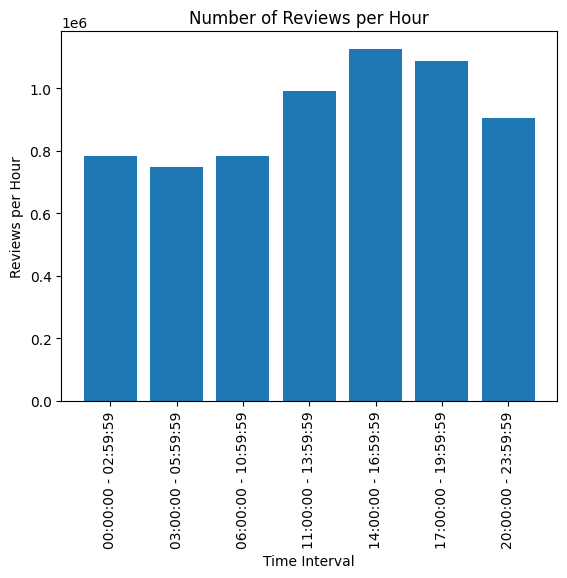

In [25]:
intervals = [
    ("00:00:00", "02:59:59"),
    ("03:00:00", "05:59:59"),
    ("06:00:00", "10:59:59"),
    ("11:00:00", "13:59:59"),
    ("14:00:00", "16:59:59"),
    ("17:00:00", "19:59:59"),
    ("20:00:00", "23:59:59"),
]

plot_reviews_per_hour(df_combined, intervals)

In [ ]:
del data_frames
del df_combined
del chunk

## [RQ 4]

---

*Investigating whether users who spend more time using an application give higher or lower ratings.*

* *Analyze the relationship between the amount of time a user has spent on an application and their review score.*
* *Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe.*
* *Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis.*
* *Ask an LLM tool (ChatGPT, Claude AI, etc.) to interpret the statistical results of the analysis and provide potential explanations for the trends. Does the LLM suggest additional factors that could explain why users who spend more time on the app give higher or lower ratings? How can you validate the interpretations provided by the LLM?*

---

### Analyze the relationship between the amount of time a user has spent on an application and their review score

### Do more experienced users (who have used the application longer) tend to give higher or lower ratings? Comment on any trends you observe

### Plot the distribution of review scores based on different user experience levels (e.g., new users vs. veteran users). Is there a statistical difference in the score distributions? Use an appropriate statistical test to validate your hypothesis

## [RQ 5]

---
*It is interesting to explore the top reviewers to gain insight into their demographic location, the quality of their reviews, and the applications they tend to review most frequently*

* *Determine the ten reviewers with the highest number of reviews in the dataset*
* *What is the percentage of each language used by these top 10 reviewers when submitting a review?*
* *Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see.*
* *Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order*
---

Create the combined DataFrame for answering [RQ 5]

In [28]:
# set chunk size: 1 million
chunksize = 1000000
# empty list to store the dataframes
data_frames = []

# Iterate over the dataset in chunks
# usecols: considering just the columns below
for chunk in pd.read_csv(dataset_filepath, chunksize=chunksize, usecols=['app_id',
                                                                         'app_name',
                                                                         'review_id',
                                                                         'language',
                                                                         'votes_helpful',
                                                                         'weighted_vote_score',
                                                                         'timestamp_created', 'timestamp_updated',
                                                                         'author.steamid',
                                                                         'author.num_games_owned']):
    data_frames.append(chunk)

# Concatenate the chunks into a single dataframe
df_combined = pd.concat(data_frames, ignore_index=True)

### Determine the ten reviewers with the highest number of reviews in the dataset

In [29]:
reviewer_counts = df_combined.groupby('author.steamid')['review_id'].count().sort_values(ascending=False)
top_10_reviewers = reviewer_counts.head(10)
print("\nTop 10 reviewers by review count:")
print(top_10_reviewers.to_markdown(numalign="left", stralign="left", tablefmt="grid"))


Top 10 reviewers by review count:
+-------------------+-------------+
| author.steamid    | review_id   |
+===================+=============+
| 76561198062813911 | 149         |
+-------------------+-------------+
| 76561198315585536 | 132         |
+-------------------+-------------+
| 76561198192166873 | 107         |
+-------------------+-------------+
| 76561198239163744 | 106         |
+-------------------+-------------+
| 76561198045381877 | 103         |
+-------------------+-------------+
| 76561198064946151 | 100         |
+-------------------+-------------+
| 76561198013146396 | 99          |
+-------------------+-------------+
| 76561198027973295 | 96          |
+-------------------+-------------+
| 76561197969749884 | 88          |
+-------------------+-------------+
| 76561197989746995 | 86          |
+-------------------+-------------+


### What is the percentage of each language used by these top 10 reviewers when submitting a review?

In [30]:
# Filter reviews by top 10 reviewers
top_reviewers_df = df_combined[df_combined['author.steamid'].isin(top_10_reviewers.index)]

# Calculate language distribution
language_distribution = top_reviewers_df.groupby('language')['review_id'].count()
language_percentages = (language_distribution / language_distribution.sum()) * 100

print("\nPercentage of each language for the top 10 reviewers:")
print(language_percentages.to_markdown(numalign="left", stralign="left", tablefmt="grid"))


Percentage of each language for the top 10 reviewers:
+------------+-------------+
| language   | review_id   |
+============+=============+
| english    | 53.94       |
+------------+-------------+
| russian    | 28.1426     |
+------------+-------------+
| schinese   | 17.9174     |
+------------+-------------+


### Let's examine whether other users found the reviews from these top 10 reviewers helpful or if they were simply spamming. Calculate the average number of valuable votes these reviewers received for their submitted reviews. Elaborate on the results you see

We have identified potential spammers, that is, users who have written many reviews but have not been considered useful by other users (for example the author 76561198062813911, who is the user who has contributed most of all the others in terms of review)

In [31]:
reviewer_counts = df_combined.groupby('author.steamid')['review_id'].count().sort_values(ascending=False)
top_10_reviewers = reviewer_counts.head(10)

# Calculate average 'votes_helpful' for each reviewer
top_reviewer_ids = top_10_reviewers.index  # Get the reviewer IDs

# Calculate average 'votes_helpful' for each top reviewer
avg_helpful_votes = df_combined[df_combined['author.steamid'].isin(top_reviewer_ids)] \
    .groupby('author.steamid')['votes_helpful'].mean()

# Add the average 'votes_helpful' as a new column to top_10_reviewers
top_10_reviewers = top_10_reviewers.to_frame(name='review_count')  # Convert to DataFrame
top_10_reviewers['avg_helpful_votes'] = avg_helpful_votes

# Print the updated table
print("\nTop 10 reviewers by review count (with avg_helpful_votes):")
print(top_10_reviewers.to_markdown(numalign="left", stralign="left", tablefmt="grid"))


Top 10 reviewers by review count (with avg_helpful_votes):
+-------------------+----------------+---------------------+
| author.steamid    | review_count   | avg_helpful_votes   |
+===================+================+=====================+
| 76561198062813911 | 149            | 0.885906            |
+-------------------+----------------+---------------------+
| 76561198315585536 | 132            | 49.7121             |
+-------------------+----------------+---------------------+
| 76561198192166873 | 107            | 38.8972             |
+-------------------+----------------+---------------------+
| 76561198239163744 | 106            | 7.64151             |
+-------------------+----------------+---------------------+
| 76561198045381877 | 103            | 2.25243             |
+-------------------+----------------+---------------------+
| 76561198064946151 | 100            | 3.99                |
+-------------------+----------------+---------------------+
| 76561198013146396 | 99 

### Create a plot showing the distribution of the number of reviews each application received from the top 10 reviewers, arranged in descending order

This research could suggest which types of games generate the most interest in the most loyal and engaged users on the platform.

In the table below we have limited the list to the top twenty apps that have received the most comments from the ten top reviewers.

In [32]:
# Filter reviews by top 10 reviewers
top_reviewers_df = df_combined[df_combined['author.steamid'].isin(top_10_reviewers.index)]

# Group by app_id and count reviews
app_review_counts = top_reviewers_df.groupby(['app_id', 'app_name'])['review_id'].count().sort_values(ascending=False).head(20)

# Create the table
app_review_table = pd.DataFrame({
    'app_id': app_review_counts.index.get_level_values(0),
    'app_name': app_review_counts.index.get_level_values(1),
    'review_count': app_review_counts.values
})

app_review_table

,app_id,app_name,review_count
0,367520,Hollow Knight,14
1,203160,Tomb Raider,10
2,377160,Fallout 4,10
3,238460,BattleBlock Theater,9
4,359550,Tom Clancy's Rainbow Six Siege,9
5,4000,Garry's Mod,9
6,381210,Dead by Daylight,9
7,218620,PAYDAY 2,9
8,292030,The Witcher 3: Wild Hunt,9
9,489830,The Elder Scrolls V: Skyrim Special Edition,9


## [RQ 6]

---
*Let's investigate the behavior of specific groups, specifically focusing on English and Spanish reviewers*

* *Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?*
* *Provide the average number of games that reviewers from each group have on their Steam accounts and the average number of games for which they write reviews. What can you say about the number you just calculated?*
---

### Which group is more likely to edit or update their review after submitting it? “English or Spanish!”?

In [33]:
# Filter reviews for English and Spanish languages
english_reviews = df_combined[df_combined['language'] == 'english']
spanish_reviews = df_combined[df_combined['language'] == 'spanish']

# Calculate the percentage of updated reviews for each language
english_updated_percentage = (english_reviews['timestamp_updated'] != english_reviews['timestamp_created']).mean()
spanish_updated_percentage = (spanish_reviews['timestamp_updated'] != spanish_reviews['timestamp_created']).mean()

print(f"Percentage of updated English reviews: {english_updated_percentage:.2f}%")
print(f"Percentage of updated Spanish reviews: {spanish_updated_percentage:.2f}%")

# Compare percentage and determine which group is more likely to update reviews
if english_updated_percentage > spanish_updated_percentage:
    print("English reviewers are more likely to update their reviews.")
elif spanish_updated_percentage > english_updated_percentage:
    print("Spanish reviewers are more likely to update their reviews.")
else:
    print("Both groups have similar likelihoods of updating their reviews.")

Percentage of updated English reviews: 0.12%
Percentage of updated Spanish reviews: 0.10%
English reviewers are more likely to update their reviews.
